In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import os
print(os.listdir("/Users/sriramreddy/Downloads/523/ex1/train/"))

['freshbanana', '.DS_Store', 'rottenbanana', 'freshoranges', 'freshapples', 'rottenoranges', 'rottenapples']


I've borrowed the code to grab the data from https://www.kaggle.com/gaborvecsei/fruit-juice-mix-of-pca-random-forest-svm to speed things up -- I'm focusing just on the neural network aspects of the project. Thank you user gaborvecsei!

I have borrowed the code to augment the data from https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9
 from the github link provided in that website. 
 (tensor flow inbuilt resize image)

## Data Resizing and Augmentation technique
## Training Set

In [29]:
fruit_images = []
labels = [] 
for fruit_dir_path in glob.glob("/Users/sriramreddy/Downloads/523/ex1/train/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (110, 110))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        #why do we need to convert the RGB2BGR
        #I don't think it is going to affect training
        #BGR was a choice made for historical reasons and now we have to live with it.
        #In other words, BGR is the horse’s ass in OpenCV.
        fruit_images.append(image)
        labels.append(fruit_label)
print(type(fruit_images))
fruit_images = np.array(fruit_images)
print("type and shape of fruit_image", type(fruit_images),np.shape(fruit_images))
labels = np.array(labels)

<class 'list'>
type and shape of fruit_image <class 'numpy.ndarray'> (1213, 110, 110, 3)


In [30]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [31]:
print(label_to_id_dict)
id_to_label_dict

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


{0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}

In [32]:
label_ids = np.array([label_to_id_dict[x] for x in labels])
label_to_id_dict

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [33]:
fruit_images.shape, label_ids.shape, labels.shape

((1213, 110, 110, 3), (1213,), (1213,))

So, fruit_images contains our image files, label_ids has the numeric translation of our labels, and labels contains the name of the fruits themselves.

## Test Set:

The data provided calls this "validation", but we'll use it as our test set.

In [34]:
validation_fruit_images = []
validation_labels = [] 
for fruit_dir_path in glob.glob("/Users/sriramreddy/Downloads/523/ex1/test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (110, 110))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [35]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])

In [36]:
validation_fruit_images.shape, validation_label_ids.shape

((298, 110, 110, 3), (298,))

## Splitting the Data

In [37]:
X_train, X_test = fruit_images, validation_fruit_images
Y_train, Y_test = label_ids, validation_label_ids

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Make a flattened version for some of our models
X_flat_train = X_train.reshape(X_train.shape[0], 110*110*3)
X_flat_test = X_test.reshape(X_test.shape[0], 110*110*3)

#One Hot Encode the Output what is this 6 
Y_train = keras.utils.to_categorical(Y_train, 6)
Y_test = keras.utils.to_categorical(Y_test, 6)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (1213, 110, 110, 3) (298, 110, 110, 3) (1213, 6) (298, 6)
Flattened: (1213, 36300) (298, 36300)


(110, 110, 3)
[1.         1.         1.         ... 0.95686275 0.95686275 0.95686275]


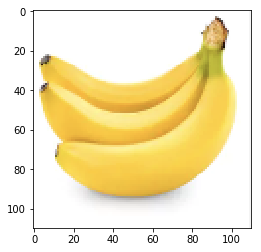

In [38]:
print(X_train[0].shape)
plt.imshow(X_train[0])
print(X_flat_train[0])
plt.show()

Cool! We've got all our images stored as 110* 110 pixel images with 3 channels for RGB, as well as a flattened version for certain models. Let's start with a simple sequential model.

## Setting Up Our Neural Network

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
#LSTM is not used
from keras.models import Model
from keras.optimizers import RMSprop, SGD
# Import the backend
from keras import backend as K

## Run a Quick Model 

Great! That's a good starting point. We're achieving ~???% accuracy on the test set using a neural network with two dense layers (128 nodes and 64 nodes) and dropout (to reduce overfitting). Let's see how much better we can do, first using a deeper network, and then using CNN.

Excellent! Deepening the network (now five hidden layers: 256, 128, 128, 128, 128) brought the test set accuracy from ??% to ??%! On to CNN -- we expect this to do the best but take significantly longer. The model above took about two minutes to train.

In [40]:
model_cnn = Sequential()
# First convolutional layer, note the specification of shape
#We are not passing flattened image of 110*110*3.
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(110, 110, 3)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(6, activation='softmax'))
#6 is the output class
#model.add(Dense(32, input_shape=(16,)))
# now the model will take as input arrays of shape (*, 16)
# and output arrays of shape (*, 32)
# after the first layer, you don't need to specify
# the size of the input anymore.  Dense should be fully connected layer.
#Dropout: A Simple Way to Prevent Neural Networks from Overfitting --- dropping out units (both hidden and visible) in a neural network

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test, Y_test))

score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1213 samples, validate on 298 samples
Epoch 1/1
1213/1213 [==============================] - 59s 49ms/step - loss: 3.0641 - acc: 0.2341 - val_loss: 1.6738 - val_acc: 0.3154
Test loss: 1.6738028806327974
Test accuracy: 0.31543624161073824


Normally I wouldn't leave this trial run in the notebook, but our CNN got up to 21% accuracy on a single epoch! Let's run it for a few more and see how well we can do.

In [41]:
model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(X_test, Y_test))
# validation_data: tuple (x_val, y_val) or tuple  (x_val, y_val, val_sample_weights) on which to evaluate the loss and any model metrics at the end of each epoch. 
# The model will not be trained on this data.  validation_data will override  validation_split.
#Model is properly getting trained 
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
#print(model_cnn.metrics_names)
#score[0] is the loss and score[1] is the accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1213 samples, validate on 298 samples
Epoch 1/25
1213/1213 [==============================] - 55s 45ms/step - loss: 1.7880 - acc: 0.2778 - val_loss: 1.6695 - val_acc: 0.2315
Epoch 2/25
1213/1213 [==============================] - 54s 44ms/step - loss: 1.6280 - acc: 0.3364 - val_loss: 1.5337 - val_acc: 0.3490
Epoch 3/25
1213/1213 [==============================] - 56s 46ms/step - loss: 1.4789 - acc: 0.4023 - val_loss: 1.3092 - val_acc: 0.4329
Epoch 4/25
1213/1213 [==============================] - 47s 39ms/step - loss: 1.1414 - acc: 0.5713 - val_loss: 0.8977 - val_acc: 0.6879
Epoch 5/25
1213/1213 [==============================] - 47s 39ms/step - loss: 1.4744 - acc: 0.4295 - val_loss: 1.2369 - val_acc: 0.5000
Epoch 6/25
1213/1213 [==============================] - 48s 40ms/step - loss: 1.2722 - acc: 0.5078 - val_loss: 1.1068 - val_acc: 0.6342
Epoch 7/25
1213/1213 [==============================] - 48s 39ms/step - loss: 1.0229 - acc: 0.6035 - val_loss: 1.1494 - val_acc: 0.5705
E

Our accuracy on the test set is topping out around ???%, even as the model starts to slightly overfit the training set (???% accuracy). We actually get there after 23 epochs. This is a great result -- we can identify fruits???

In [70]:
#fname="/Users/sriramreddy/Downloads/523/ex1/new_model_6_classes.hdf5"
#model_cnn.save_weights(fname,overwrite=True)
#In future, you can use this model and later you can load this model for prediction 
#Creation of dictionary with mapping between id and labels
# s=[3,4,5]
# for i in enumerate(s):
#     print(i)
# print("second")
# for i in enumerate(s,10):
#     print(i)
# print("third")
# for i,k in enumerate(s):
#     print(i,k) np.unique returns a sorted array 

In [42]:
output=model_cnn.predict(X_test, batch_size=None, verbose=0, steps=None)
print(output)

[[1.48638757e-03 9.93843436e-01 9.71652207e-06 8.41219036e-04
  1.89065281e-03 1.92870852e-03]
 [7.40602263e-04 9.67226803e-01 6.86839703e-05 7.95869064e-03
  2.67214631e-03 2.13331748e-02]
 [6.07467484e-07 9.99859333e-01 2.36647342e-08 2.32974458e-06
  2.31185149e-05 1.14523078e-04]
 ...
 [8.17472860e-03 1.24188908e-03 3.27403918e-02 9.33146715e-01
  5.05069038e-04 2.41912790e-02]
 [6.66339919e-02 1.23963505e-03 1.25293415e-02 9.09734011e-01
  2.70171673e-04 9.59296152e-03]
 [3.62356019e-04 6.12806417e-02 7.58996393e-05 9.37570810e-01
  3.38240323e-04 3.72024981e-04]]


In [66]:
id_labels={0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}
accuracy={}
infi,infi_set=0,0
for k,v in id_labels.items():
    total_set,count=0,0
    for i in glob.glob("/Users/sriramreddy/Downloads/523/ex1/test/"+v+"/*png"):
        test_image = image.load_img(i, target_size = (110, 110))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = model_cnn.predict(test_image)
        total_set+=1
        infi_set+=1
        #print(k,v,np.argmax(result[0]))
        if k==np.argmax(result[0]): #key_with_maximum_value_in_array result[0][k] >= 0.5:
            count+=1
            infi+=1
    accuracy[k]=count/total_set
    print(v,accuracy[k])
print("Accuracy for all items", infi/infi_set)

freshapples 0.4146341463414634
freshbanana 0.9761904761904762
freshoranges 0.9166666666666666
rottenapples 0.5373134328358209
rottenbanana 0.14545454545454545
rottenoranges 0.3111111111111111
Accuracy for all items 0.5369127516778524


In [50]:
# id_labels={0: 'freshapples',
#  1: 'freshbanana',
#  2: 'freshoranges',
#  3: 'rottenapples',
#  4: 'rottenbanana',
#  5: 'rottenoranges'}
# print(id_labels.items())
# import numpy as np
# from keras.preprocessing import image
# accuracy={}
# infi,infi_set=0,0
# total_set,count=0,0
# i="/Users/sriramreddy/Downloads/523/apple.png"
# test_image = image.load_img(i, target_size = (110, 110))
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis = 0)
# result = model_cnn.predict(test_image)
# total_set+=1
# infi_set+=1
# if result[0][0] >= 0.5:
#     count+=1
#     infi+=1
# print(result)

dict_items([(0, 'freshapples'), (1, 'freshbanana'), (2, 'freshoranges'), (3, 'rottenapples'), (4, 'rottenbanana'), (5, 'rottenoranges')])
[[1. 0. 0. 0. 0. 0.]]


In [55]:
# id_labels={0: 'freshapples',
#  1: 'freshbanana',
#  2: 'freshoranges',
#  3: 'rottenapples',
#  4: 'rottenbanana',
#  5: 'rottenoranges'}
# accuracy={}
# infi,infi_set=0,0
# for k,v in id_labels.items():
#     total_set,count=0,0
#     for i in glob.glob("/Users/sriramreddy/Downloads/523/ex1/test/"+v+"/*png"):
#         test_image = image.load_img(i, target_size = (110, 110))
#         test_image = image.img_to_array(test_image)
#         test_image = np.expand_dims(test_image, axis = 0)
#         print(np.shape(test_image))
#         result = model_cnn.predict(test_image)
#         print(result,k)
# #         total_set+=1
# #         infi_set+=1
# #         if result[0][k] >= 0.5:
# #             count+=1
# #             infi+=1
# #     accuracy[k]=count/total_set
# #     print(v,accuracy[k])
# # print("Accuracy for all items", infi/infi_set)

(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0.0000000e+00 0.0000000e+00 9.7708425e-32 1.0000000e+00 0.0000000e+00
  0.0000000e+00]] 0
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 0
(1, 110, 110, 3)
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 1.6682441e-16 0.0000000e+00
  0.0000000e+00]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[1. 0. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 0
(1,

[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0.00000e+00 1.00000e+00 0.00000e+00 5.57278e-18 0.00000e+00 0.00000e+00]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0.00000e+00 1.94686e-15 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00]] 3
(1, 110, 110, 3)
[[0. 0. 0. 1. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 1. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 3
(1, 110, 110, 3)
[[0. 0. 0. 0. 1. 0.]] 4
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 4
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 4
(1, 110, 110, 3)
[[0. 1. 0. 0. 0. 0.]] 4
(1, 110, 110, 3)
[[0.0000000e+00 0.0000000e+00 0

In [62]:
suggest=model_cnn.predict(X_test)
file = open('test','w') 
file.writelines(suggest)
file.write("This is the begin")
file.write(Y_test)
file.close()

TypeError: write() argument must be str, not numpy.ndarray

In [ ]:
with open(“hello.txt”, “w”) as f:
    f.write(“Hello World”)